In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests, json
import time
from scipy.stats import linregress

# Import API key
#from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Input File (CSV)
input_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

In [29]:
clean_city_data = pd.read_csv(input_data_file)

In [30]:
clean_city_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321 entries, 0 to 1320
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1321 non-null   int64  
 1   City         1321 non-null   object 
 2   Latitude     1321 non-null   float64
 3   Longitude    1321 non-null   float64
 4   Max Temp     1321 non-null   float64
 5   Wind Speed   1321 non-null   float64
 6   Cloudiness   1321 non-null   float64
 7   Description  1321 non-null   object 
 8   Humidity     1321 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 93.0+ KB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319 entries, 361 to 976
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1319 non-null   int64  
 1   City                 1319 non-null   object 
 2   Latitude             1319 non-null   float64
 3   Longitude            1319 non-null   float64
 4   Max Temp             1319 non-null   float64
 5   Wind Speed           1319 non-null   float64
 6   Cloudiness           1319 non-null   float64
 7   Description          1319 non-null   object 
 8   Humidity             1319 non-null   float64
 9   Augmented Longitude  1319 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 113.4+ KB


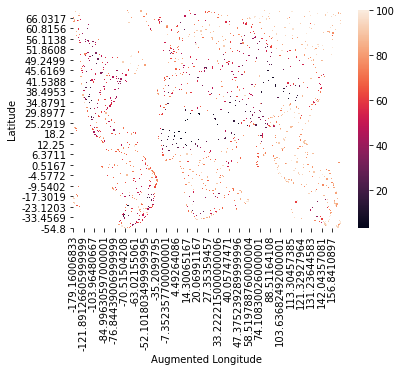

In [36]:
clean_city_data['Augmented Longitude']=clean_city_data['Longitude']+0.0001*clean_city_data['Latitude']
clean_city_data.sort_values("Augmented Longitude", inplace = True)
clean_city_data.drop_duplicates(subset ="Augmented Longitude",keep = False, inplace = True)
clean_city_data.info()

import seaborn as sns
data = clean_city_data.pivot(index='Latitude',columns='Augmented Longitude',values='Humidity')
ax = sns.heatmap(data)
ax.invert_yaxis()

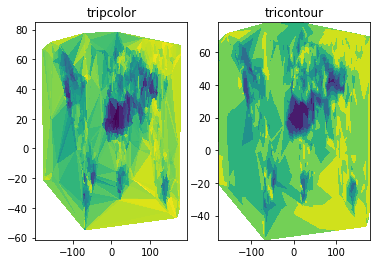

In [37]:
fig, (ax, ax2)=plt.subplots(ncols=2)
ax.set_title("tripcolor")
ax.tripcolor(clean_city_data["Longitude"], clean_city_data["Latitude"], clean_city_data["Humidity"])
ax2.set_title("tricontour")
ax2.tricontourf(clean_city_data["Longitude"], clean_city_data["Latitude"], clean_city_data["Humidity"])

plt.show()

In [42]:
import folium
from folium.plugins import MarkerCluster

#empty map
world_map= folium.Map(tiles="cartodbpositron")

marker_cluster = MarkerCluster().add_to(world_map)

#for each coordinate, create circlemarker of user percent
for i in range(len(clean_city_data)):
        lat = clean_city_data.iloc[i]['Latitude']
        long = clean_city_data.iloc[i]['Longitude']
        radius=5
        folium.CircleMarker(location = [lat, long], radius=radius, fill =True).add_to(marker_cluster)


world_map